# Attention seq2seq - Pytorch

Dataset: http://svn.code.sf.net/p/cmusphinx/code/trunk/cmudict/cmudict-0.7b

In [1]:
%matplotlib inline

import numpy as np
import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as F
from torch.autograd import Variable
from torch import optim
import re
import time, math
from sklearn.model_selection import train_test_split

Path = 'data/'

## Preprocessing

In [2]:
#Get each word that begins with A-Z from each line into a list 
lines = [l.strip().split("  ") for l in open(Path+'cmudict-0.7b', encoding='latin1') 
         if re.match('^[A-Z]', l)]
#Split words and phonemes
lines = [(w, ps.split()) for w, ps in lines]
lines[0]

('A', ['AH0'])

In [3]:
#Get a list of all the unique phonemes from lines and adding _ to position 0 because it corresponds to padding
#when tokenised
phonemes = ["_"]+sorted(set(p for w, ps in lines for p in ps))
len(phonemes)

70

In [4]:
#Map phonemes to indices and letters to indices.
p2i = dict((v, k) for k, v in enumerate(phonemes))
letters = "_abcdefghijklmnopqrstuvwxyz*"
l2i = dict((v, k) for k, v in enumerate(letters))

In [5]:
#Start of sentence token
SOS_token = 0

In [6]:
maxlen = 15
#Map words to corresponding list of phoneme indices. Constraint
pronounce_dict = {w.lower(): [p2i[p] for p in ps] for w, ps in lines
                    if (5<=len(w)<=maxlen) and re.match("^[A-Z]+$", w)}
len(pronounce_dict)

108006

In [7]:
maxlen_p = max([len(v) for k,v in pronounce_dict.items()]); maxlen_p

16

In [8]:
#words contain the number of words in the filtered dictionary
words = np.random.permutation(list(pronounce_dict.keys()))
n = len(words)

#Initialise the input and labels array with zeros so that everywhere except 
#the position of values is padded
input_ = np.zeros((n, maxlen_p), np.int32)
labels_ = np.zeros((n, maxlen), np.int32)

#Fill in the non zero indices
for i, k in enumerate(words):
    for j, p in enumerate(pronounce_dict[k]): input_[i][j]=p
    for j, p in enumerate(k): labels_[i][j] = l2i[p]
        

In [9]:
#Create train, validation sets
(input_train, input_test, labels_train, labels_test, 
    ) = train_test_split(input_, labels_, test_size=0.1)

In [10]:
input_vocab_size, output_vocab_size = len(phonemes), len(letters);input_vocab_size, output_vocab_size

(70, 28)

In [11]:
dim = 240

In [12]:
def get_batch(x, y, batch_size=128):
    idxs = np.random.permutation(len(x))[:batch_size]
    return x[idxs], y[idxs]

## Model


In [13]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size//2)
        self.grubi = nn.GRU(hidden_size//2, hidden_size//2, dropout=0.1, batch_first=True, num_layers=1,
                         bidirectional=True)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True, dropout=0.1,
                            num_layers=1)
        
    def forward(self, input, hidden):
        #print ('encoder inputs input and hidden = ', input.size(), hidden.size())
        #print ('encoder embedding', (self.embedding(input)).size())
        x, hidden = self.grubi(self.embedding(input), hidden)
        h1,h2 = torch.chunk(hidden, 2, 0)
        hidden = torch.cat((h1,h2),2)
        output, hidden = self.gru(x, hidden)
        #print ('Encoder output-hidden = ', output.size(), hidden.size())
        return output, hidden

    # TODO: other inits
    def initHidden(self, batch_size):
        return Variable(torch.zeros(2, batch_size, self.hidden_size//2))

In [14]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True, num_layers=1)
        self.gru2 = nn.GRU(hidden_size, hidden_size, batch_first=True, num_layers=1)

        # TODO use transpose of embedding
        self.out = nn.Linear(hidden_size, output_size)
        self.sm = nn.LogSoftmax()
        
    def forward(self, input, hidden):
        #print ('decoder inputs input and hidden = ', input.size(), hidden.size())
        #emb = self.embedding(input).unsqueeze(1)
        #print ('decoder input = ', emb.size())
        # NB: Removed relu
        res, hidden = self.gru(input, hidden)
        #res, hidden = self.gru2(res, hidden)
        #print ('decoder output-hidden = ', res.size(), hidden.size())
        output = self.sm(self.out(res[:,0]))
        #print ('final output = ', output.size())
        return output, hidden

In [15]:
input_vocab_size, output_vocab_size, dim

(70, 28, 240)

In [16]:
def train(input_variable, target_variable, encoder, decoder, 
          encoder_optimizer, decoder_optimizer, criterion):
    batch_size, input_length = input_variable.size()
    target_length = target_variable.size()[1]
    encoder_hidden = encoder.initHidden(batch_size).cuda()
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    loss = 0

    encoder_output, encoder_hidden = encoder(input_variable, encoder_hidden)
    
    decoder_input = encoder_hidden.squeeze()
    decoder_input = decoder_input.unsqueeze(1)
    #print ('MMYYYY',decoder_input.size())
    decoder_hidden = encoder_hidden

    for di in range(target_length):
        decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)          
                #, encoder_output, encoder_outputs)
        targ = target_variable[:, di]
        #print(decoder_output.size(), targ.size(), target_variable.size())
        loss += criterion(decoder_output, targ)
        #_, indices = torch.max(decoder_output, 1)
        #decoder_input = indices
        
    
    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()
    return loss.data[0] / target_length

In [17]:
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [69]:
def trainIters(encoder, decoder, n_epochs, print_every=1000, plot_every=100, 
                learning_rate=0.01):
    start = time.time()    
    start = time.time()
    plot_losses = []
    print_loss_total = 0 # Reset every print_every
    plot_loss_total = 0 # Reset every plot_every
    
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate, betas=(0.5, 0.999))
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate, betas=(0.5, 0.999))

    criterion = nn.NLLLoss().cuda()
   
    for epoch in range(1, n_epochs + 1):
        training_batch = get_batch(input_train, labels_train, 128)

        input_variable = Variable(torch.LongTensor((training_batch[0].astype('int64')))).cuda()
        target_variable = Variable(torch.LongTensor(training_batch[1].astype('int64'))).cuda()
        
        loss = train(input_variable, target_variable, encoder, decoder, encoder_optimizer, 
                             decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs), epoch, 
                                         epoch / n_epochs * 100, print_loss_avg))
        
        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
    
    showPlot(plot_losses)

In [70]:
encoder = EncoderRNN(input_vocab_size, dim).cuda()
decoder = DecoderRNN(dim, output_vocab_size).cuda()

In [71]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2) # this locator puts ticks at regular intervals
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

0m 12s (- 6m 12s) (500 3%) 0.2088
0m 25s (- 6m 0s) (1000 6%) 0.2048
0m 38s (- 5m 47s) (1500 10%) 0.2040
0m 51s (- 5m 33s) (2000 13%) 0.1953
1m 4s (- 5m 20s) (2500 16%) 0.1907
1m 16s (- 5m 6s) (3000 20%) 0.1873
1m 29s (- 4m 52s) (3500 23%) 0.1853
1m 41s (- 4m 39s) (4000 26%) 0.1787
1m 54s (- 4m 26s) (4500 30%) 0.1773
2m 7s (- 4m 14s) (5000 33%) 0.1734
2m 19s (- 4m 1s) (5500 36%) 0.1698
2m 32s (- 3m 48s) (6000 40%) 0.1661
2m 44s (- 3m 35s) (6500 43%) 0.1641
2m 57s (- 3m 22s) (7000 46%) 0.1630
3m 9s (- 3m 9s) (7500 50%) 0.1587
3m 22s (- 2m 57s) (8000 53%) 0.1539
3m 34s (- 2m 44s) (8500 56%) 0.1563
3m 47s (- 2m 31s) (9000 60%) 0.1499
4m 0s (- 2m 19s) (9500 63%) 0.1454
4m 12s (- 2m 6s) (10000 66%) 0.1441
4m 25s (- 1m 53s) (10500 70%) 0.1515
4m 38s (- 1m 41s) (11000 73%) 0.1399
4m 51s (- 1m 28s) (11500 76%) 0.1334
5m 3s (- 1m 15s) (12000 80%) 0.1355
5m 16s (- 1m 3s) (12500 83%) 0.1337
5m 28s (- 0m 50s) (13000 86%) 0.1364
5m 41s (- 0m 37s) (13500 90%) 0.1318
5m 53s (- 0m 25s) (14000 93%) 0.13

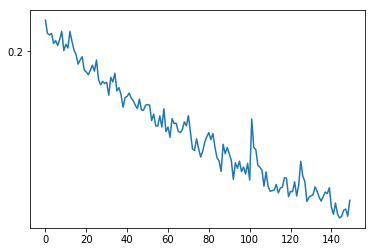

In [78]:
trainIters(encoder, decoder, 15000, print_every=500, learning_rate=0.0005)

In [79]:
test_batch = get_batch(input_test, labels_test)

input_variable = Variable(torch.LongTensor((test_batch[0].astype('int64')))).cuda()
target_variable = Variable(torch.LongTensor(test_batch[1].astype('int64'))).cuda()

batch_size, input_length = input_variable.size()
target_length = target_variable.size()[1]
encoder_hidden = encoder.initHidden(batch_size).cuda()
    
encoder_output, encoder_hidden = encoder(input_variable, encoder_hidden)
#decoder_input = Variable(torch.LongTensor([SOS_token]*batch_size)).cuda()
decoder_input = encoder_hidden.squeeze()
decoder_input = decoder_input.unsqueeze(1)
decoder_hidden = encoder_hidden
decoded_words = []
for di in range(target_length):
    decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)          
    _, indices = torch.max(decoder_output, 1)
    decoded_words.append(indices)
    #decoder_input = indices

In [80]:
combine = []
for x in decoded_words:
    combine.append(x.cpu().data.numpy())

In [81]:
combine = np.array(combine)

In [82]:
combine.shape

(15, 128)

In [90]:
input_test1=test_batch[0]
labels_test1=test_batch[1]
print ('  Phonemes_________________________________predictions____________label')
for index in range(128):
    phoneme = '-'.join([phonemes[p] for p in input_test1[index]])
    prediction = [letters[l] for l in combine[:, index]]
    real = [letters[l] for l in labels_test1[index]]
    print ('  ',phoneme.strip('-_').ljust(40), ''.join(prediction).strip('_').ljust(20), 
           ''.join(real).strip('_'))

  Phonemes_________________________________predictions____________label
   Z-IH1-P-K-AE2-R                          zipkar               zipcar
   T-UW2-P-EY1                              topey                toupee
   G-R-AE1-S-OW0                            grasso               grasso
   K-OW0-M-AA1-T-S-UW1                      komotuu              komatsu
   B-AH0-K-AA1-S-AH0                        bakasa               bokassa
   TH-IH1-K-L-IY0                           thiclly              thickly
   W-AO1-K-S                                wahks                wachs
   W-UH1-L-S-T-AH0-N                        wollston             woolston
   M-IH1-SH-R-AH0                           mishra               mishra
   R-EH2-V-AH0-L-UW1-SH-AH0-N-EH2-R-IY0-Z   revolutionaries      revolutionaries
   B-IH0-M-OW1-N                            bemoen               bemoan
   S-K-R-OW1-L                              scroll               scroll
   M-IH1-S-IH0-V                            missive

In [87]:
torch.save(encoder, 'models/encoder.dat')

/opt/anaconda/lib/python3.6/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type EncoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [88]:
torch.save(decoder, 'models/decoder.dat')

/opt/anaconda/lib/python3.6/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
